### NAME: ISAQ M. TUNA
### STUDENT NUMBER: 1087936
### TRANSIENT GROUNDWATER FLOW DYNAMICS ASSIGNMENT 

#### Corrected and optimized by Theo Olsthoorn, March 25 2024

# Imports

In [56]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc, k0 as K0, exp1, exp1 as Wt
from scipy.integrate import quad
from scipy.signal import lfilter, convolve
import pandas as pd
from PIL import Image
from glob import glob # @TO Handy to search directories and files using wildcards '*'
from itertools import cycle
from scipy.optimize import curve_fit
from pprint import pprint

# Useful functions

In [3]:
def newfig(title='title', xlabel='xlabel', ylabel='ylabel', xscale='linear', yscale='linear',
           xlim=None, ylim=None, figsize=(6, 6)):
    """Return ax of new figure."""
    fig, ax = plt.subplots(1, 1)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    if xlim: ax.set_xlim(xlim)
    if ylim: ax.set_ylim(ylim)
    if xscale: ax.set_xscale(xscale)
    if yscale: ax.set_yscale(yscale)
    if figsize: fig.set_size_inches = figsize
    ax.grid(True)
    return ax

In [4]:
def wgs2km(lam_phi, verbose=False):
    """Return approximate xy [km] from (easting) longitude [deg], (northing) [deg] (lamphi)

    Parameters
    ----------
    lamphi: ndarray (n, 2)
        np.array([lam, phi])
        lam: longitude (easting) in degfees
        phi: latitude (northing) in degrees
    verbose: bool
        if True print extra info
    """
    R = 6378.0 # km
    assert isinstance(lam_phi, np.ndarray) and lam_phi.ndim==2 and lam_phi.shape[1] == 2, 'lam_phi must be 2D-array [[lam, phi]]'
    
    lam, phi = lam_phi.T * np.pi / 180.
    if verbose:
        print(lam, phi)
    y = R * phi
    x = R * np.cos(phi) * lam
    xy = np.vstack((x, y)).T
    if verbose:
        print(xy)
    return xy.round(1)


In [5]:
def Wh(u, rho=0):
    """Return Hantush well function values.

    This function uses numerical integration with scipy.ingegratge.quad
    and vectorizes the obtainded functions to use it with arrays of input.
    
    The resulting function is extremely fast and accurate!

    Parameters
    ----------
    u : float | nd.array of floats
        u = r^2 / (4 kD t)
    rho: float | None
        r / lambda with lambda = sqrt(kD c)

    Some exmple uses
    ----------------
    
    >>>Wh(0.004, 0.03)
    4.894104204671381

    
    >>>Wh(0.08, 0.06)
    2.0184074022446836

    >>>Wh(0.08) # Use Wh without rho, to get the Theis well function value
    2.0269410025857217

    >>>Wt(0.08) # Show that the Theis well funciton Wt(u) = Wh(u)
    2.0269410025857417
    
    """
    def kernel(y, rho):
        """Return the function to be integrated."""
        return np.exp(-y - (rho / 2) ** 2 / y) / y
    def w(u, rho): # Integrate the argument
        # return quad(kernel, u, rho/2, args=(rho,))[0] + K0(rho / 2)
        return quad(kernel, u, np.inf, args=(rho,))[0]
    wh = np.frompyfunc(w, 2, 1) # Vectorize function w(u, rho) so we can use arrays as input.
    
    return np.asarray(wh(u, rho), dtype=float)

print(Wh(0.004, 0.03))
print(Wh(0.08, 0.06))
print(Wh(0.08))
print(Wt(0.08))


4.894104204671381
2.0184074022446836
2.0269410025857217
2.0269410025857417


## Directory names

In [6]:
HOME   = os.path.join(os.environ['HOME'], 'Entiteiten/IHE/IHE2023-2024/Assignment/ToTheStudents/Isaq_Tuna')
DATA   = os.path.join(HOME, 'data')
IMAGES = os.path.join(HOME, 'images')
NASSER =  os.path.join(DATA, 'lake_nasser')
PTEST  =  os.path.join(DATA, 'pump_test')

for d in [HOME, DATA, IMAGES, NASSER, PTEST]:
    assert os.path.isdir(d), f"Can't fine directory <{d}> !"

os.chdir(HOME)
os.getcwd()

'/Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/ToTheStudents/Isaq_Tuna'

What data files do we have?

In [7]:
glob(DATA + '/*')

['/Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/ToTheStudents/Isaq_Tuna/data/lake_nasser',
 '/Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/ToTheStudents/Isaq_Tuna/data/PumpingSitesLybia.csv',
 '/Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/ToTheStudents/Isaq_Tuna/data/pump_test']

In [8]:
glob(NASSER + '/*')

['/Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/ToTheStudents/Isaq_Tuna/data/lake_nasser/headAt908.csv',
 '/Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/ToTheStudents/Isaq_Tuna/data/lake_nasser/headAt9497.csv',
 '/Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/ToTheStudents/Isaq_Tuna/data/lake_nasser/nasser_lake.csv',
 '/Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/ToTheStudents/Isaq_Tuna/data/lake_nasser/headAt256.csv',
 '/Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/ToTheStudents/Isaq_Tuna/data/lake_nasser/headAt30678.csv',
 '/Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/ToTheStudents/Isaq_Tuna/data/lake_nasser/headAt2972.csv']

In [9]:
glob(PTEST + '/*')

['/Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/ToTheStudents/Isaq_Tuna/data/pump_test/piez9m.csv',
 '/Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/ToTheStudents/Isaq_Tuna/data/pump_test/piez88m.csv',
 '/Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/ToTheStudents/Isaq_Tuna/data/pump_test/piez52m.csv',
 '/Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/ToTheStudents/Isaq_Tuna/data/pump_test/piez19m.csv',
 '/Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/ToTheStudents/Isaq_Tuna/data/pump_test/piez121m.csv',
 '/Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/ToTheStudents/Isaq_Tuna/data/pump_test/piez34m.csv']

## Desert Groundwater pumping in Lybia

First get the pumping sites.

In [10]:
psites_file = os.path.join(DATA, 'PumpingSitesLybia.csv')

assert os.path.isfile(psites_file), f"Can't find file <{psites_file}> !"

psites = pd.read_csv(psites_file, delimiter=',', header=0)

# use  the site name fo the sites as index, it's easire later
psites.index = psites['Name']
psites = psites.drop(labels='Name', axis=1)

print(psites.head())

                    E_GWS84    N_GWS84
Name                                  
Ghadarnes         10.870178  29.330456
Jabal_Hasouna_NE  13.026915  27.042600
Jabal_Hasouna_E   14.782520  26.308762
Tazerbo_W         20.547701  24.853721
Tazerbo_E         22.248636  23.778889


### Lybia's map with pumping sites

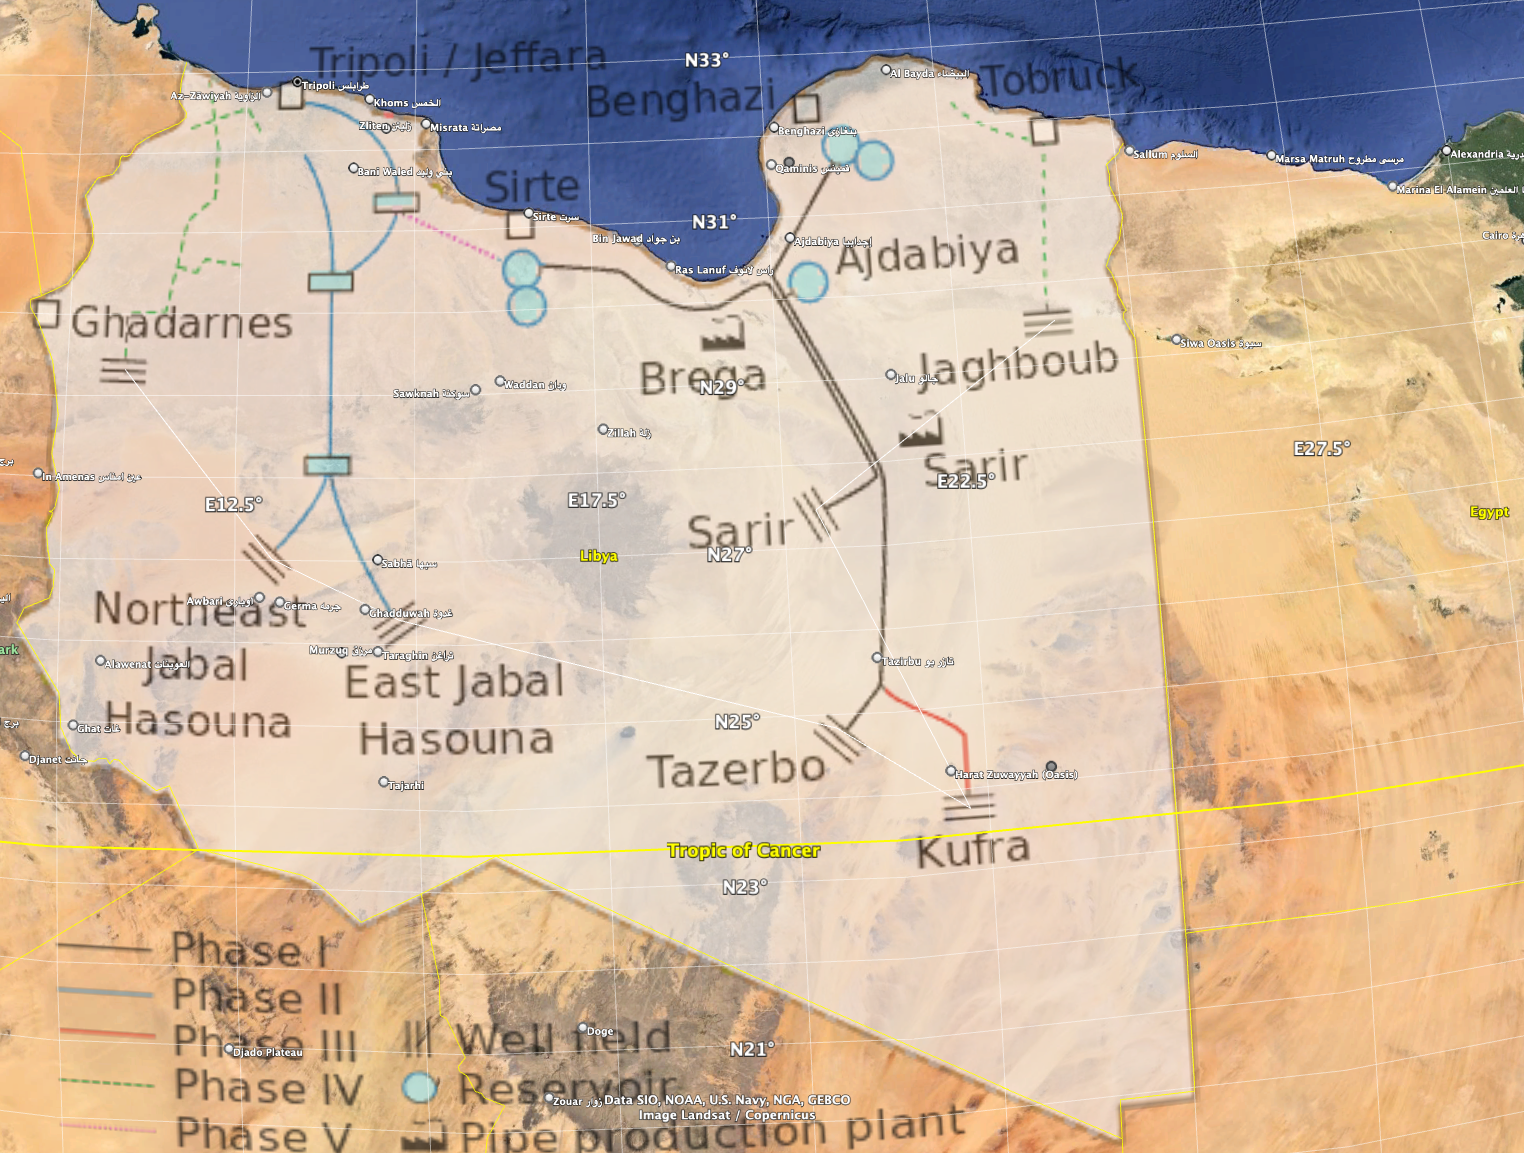

In [11]:
Lybia_egypt = Image.open(os.path.join(IMAGES, 'LybiaPumpingSites.png'))
Lybia_egypt

### Convert lon lat coordinagesto x [km], y [km] coordinates 

In [12]:
# Add the psites coordinaters in km to the DataFrame
EN = psites[['E_GWS84', 'N_GWS84']].values
xSites, ySites = wgs2km(EN).T
psites['xkm'] = xSites
psites['ykm'] = ySites
print('psites:\n')
print(psites)

# Some other points
print("\nEgypian border at Mediterranean:")
lon, lat = 25, 31
x, y = wgs2km(np.array([[lon, lat]]))[0]
print("(lon,lat)=({:.1f},{:.1f}) --> (x,y)=({:.0f},{:.0f})".format(lon, lat, x, y))


# Egyptian border point:
lon, lat = 25, 25
x, y = wgs2km(np.array([[lon, lat]]))[0]
print("(lon,lat)=({:.1f},{:.1f}) --> (x,y)=({:.0f},{:.0f})".format(lon, lat, x, y))

psites:

                    E_GWS84    N_GWS84     xkm     ykm
Name                                                  
Ghadarnes         10.870178  29.330456  1054.9  3265.0
Jabal_Hasouna_NE  13.026915  27.042600  1291.6  3010.3
Jabal_Hasouna_E   14.782520  26.308762  1475.1  2928.6
Tazerbo_W         20.547701  24.853721  2075.5  2766.6
Tazerbo_E         22.248636  23.778889  2266.4  2647.0
Sarir             20.428217  27.471861  2017.6  3058.1
Jahgboub          23.895349  29.554800  2313.9  3290.0

Egypian border at Mediterranean:
(lon,lat)=(25.0,31.0) --> (x,y)=(2385,3451)
(lon,lat)=(25.0,25.0) --> (x,y)=(2522,2783)


### Map boundaries (the extent of the map)

The latitude longitude of the map were read from the map and written down by hand (in degrees)

Notice that extent is [xmin xmax, ymin, ymax] (see doc of `ax.imshow`).

In [13]:
# The coordinates of the Google image are approximately

# lat = (19.5, 33.5) # deg
# lon = (9.5, 30) # deg

LL = ( 9.5, 19.5) # Lon Lat of lower left corner of map
UR = (30.0, 33.5) # Lon Lat of upper right corner of map

LU = np.array([LL, UR])

print("LL and UR = \n", LU)
xy = wgs2km(LU)

print("\nxy = \n", xy)

xmin, xmax, ymin, ymax = [*xy[:, 0], *xy[:, 1]]
extent = [xmin, xmax, ymin, ymax]

print('\nMap extent in km:\n xmin,   xmax,   ymin,   ymax\n', extent)

LL and UR = 
 [[ 9.5 19.5]
 [30.  33.5]]

xy = 
 [[ 996.9 2170.7]
 [2784.8 3729.1]]

Map extent in km:
 xmin,   xmax,   ymin,   ymax
 [996.9, 2784.8, 2170.7, 3729.1]


In [14]:
def plot_lybia():
    """Plot the map of Lybia with a km grid.

    Parameters
    ----------
    None
        
    returns
    -------
    ax: plt.Axes object
        axes of the axis on which the map is plotted
    """

    LU = np.array([( 9.5, 19.5),  # Lon Lat LL
                    (30.0, 33.5), # Lon Lat UR
                  ])

    x, y = wgs2km(LU).T
    extent = [x[0], x[1], y[0], y[1]]

    Lybia_egypt = Image.open(os.path.join(IMAGES, 'LybiaPumpingSites.png'))
                             
    plt.imshow(Lybia_egypt, origin='upper', extent=extent)
                             
    plt.title("Map of lybia")
    plt.xlabel("x [km from zero meridian]")
    plt.ylabel("y [km from equator]")
    plt.grid()
    return plt.gca()

### The maps with pumping sites

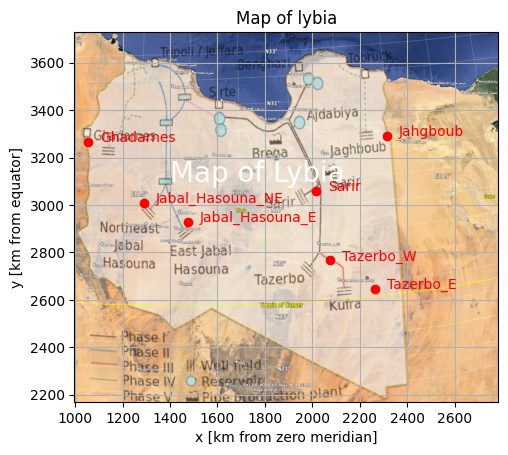

In [15]:
ax = plot_lybia()
ax.text(1400, 3100, "Map of Lybia", color='white', fontsize=20)

# Plot the pumping sites on the map
for name in psites.index:
    E, N, xkm, ykm = psites.loc[name]
    ax.plot(xkm, ykm, 'ro')
    ax.text(xkm + 50, ykm, name, color='r', fontsize=10)



# Further information:

#### The discharge per pumping site

Now take the pumping capacity given that the transport pipes have $D = 4$ m diameter serving 2 pumping sites. Just assume a flow velocity of $v = 0.5$ m/s on average. The discharge per pumping site is estimated to

$$ Q \approx \frac{1}{2} \ \pi \, \frac{D^2}{4} \, v $$

Take this as discharge per pump site.


Aquifer properties

Further, assume the transmissivity of the Nubian Sandstone is
m2/d and Finally take the Mediterranean sea as a fixed-head boundary, giving rise to mirror wells

In [16]:

D = 4  # Diameter in meters
v = 0.5  # Flow velocity in m/s

# Pumping from the Nubian Sandstone
# For every pump site the same extraction
Qps = 0.5 * np.pi * D ** 2 / 4 * v # m3/s
Qpd = Qps * 24 * 60 * 60  # Pumping rate in m³/day

psites['Qps'] = np.round(Qps, 2)
psites['Qpd'] = np.round(Qpd)

print(psites)

                    E_GWS84    N_GWS84     xkm     ykm   Qps       Qpd
Name                                                                  
Ghadarnes         10.870178  29.330456  1054.9  3265.0  3.14  271434.0
Jabal_Hasouna_NE  13.026915  27.042600  1291.6  3010.3  3.14  271434.0
Jabal_Hasouna_E   14.782520  26.308762  1475.1  2928.6  3.14  271434.0
Tazerbo_W         20.547701  24.853721  2075.5  2766.6  3.14  271434.0
Tazerbo_E         22.248636  23.778889  2266.4  2647.0  3.14  271434.0
Sarir             20.428217  27.471861  2017.6  3058.1  3.14  271434.0
Jahgboub          23.895349  29.554800  2313.9  3290.0  3.14  271434.0


### Aquifer properties

In [17]:
aqprops = {'T': 5000., 'S':0.002}

### Radius of influence:

it comes from setting the drawdown zero in the simplyfied Theis solution

$$ s = \frac Q {4 \pi kD} \ln \left(\frac{2.25 kD t}{r^2 S}\right) = 0 $$

which is the case when the argument under the logarithm is 1. Hence:

$$ r = R_{inf} = \sqrt{\frac{2.25 kD t}{S}}$$

In [18]:
def rInfluence(T, t, S):
    return np.sqrt(2.25 * T * t / S)

T = aqprops['T']  # in m^2/d
S = aqprops['S']# dimensionless

t_pumping = 365  # d

roi = rInfluence(T, t_pumping, S)
print(f"R of Influence at t = {t_pumping} d is {roi:.0f} m")

R of Influence at t = 365 d is 45311 m


### The drawdown today (assuming that the system has been working since 1984)

In [19]:
from datetime import datetime

T = aqprops['T']
S = aqprops['S']

days_since_1984 = (datetime.now() - datetime(1984, 1, 1)).days  # days since 1984
print('days_since_1984: ', days_since_1984)

dt = 1.0
t = np.arange(0, days_since_1984, dt, dtype=float)
t[0] = 0.5 * dt # @TO Prevents division by zero in 1/tau, but it's not very smart per se.

r = 1000  # m
u = r ** 2 * S / (4 * T * days_since_1984)  # using the last time value (today)
drawdown_today = Qpd / (4 * np.pi * T) * Wt(u)

print(f"\nDrawdown today at radial distance {r} meters: {drawdown_today} m")

# Distances  [m]
rs = np.array([1, 3, 10, 30, 100, 300, 1000]) * 1000.

print("The drawdown today at different distances from pumping site.\n")
for r in rs:
    u = r ** 2 * S / (4 * T * days_since_1984)
    dd_today = Qpd / (4 * np.pi * T) * Wt(u)

    print(f"For Q = {Qpd:.0f} m3/d, the ddn on {datetime.now().strftime('%Y-%m-%d')}, i.e {days_since_1984:5.0f} d since 1984, at r = {r:7.0f} m is {dd_today:.3g} m")

days_since_1984:  14697

Drawdown today at radial distance 1000 meters: 48.90574757878836 m
The drawdown today at different distances from pumping site.

For Q = 271434 m3/d, the ddn on 2024-03-28, i.e 14697 d since 1984, at r =    1000 m is 48.9 m
For Q = 271434 m3/d, the ddn on 2024-03-28, i.e 14697 d since 1984, at r =    3000 m is 39.4 m
For Q = 271434 m3/d, the ddn on 2024-03-28, i.e 14697 d since 1984, at r =   10000 m is 29 m
For Q = 271434 m3/d, the ddn on 2024-03-28, i.e 14697 d since 1984, at r =   30000 m is 19.5 m
For Q = 271434 m3/d, the ddn on 2024-03-28, i.e 14697 d since 1984, at r =  100000 m is 9.41 m
For Q = 271434 m3/d, the ddn on 2024-03-28, i.e 14697 d since 1984, at r =  300000 m is 1.91 m
For Q = 271434 m3/d, the ddn on 2024-03-28, i.e 14697 d since 1984, at r = 1000000 m is 0.000622 m


### Contour the drawdon directly on the image

In [20]:
def dd_theis(r, Q, T, t, S):
    u = r**2 * S / (4 * T * t)
    return Q / (4 * np.pi * T) * Wt(u)

<a list of 17 text.Text objects>

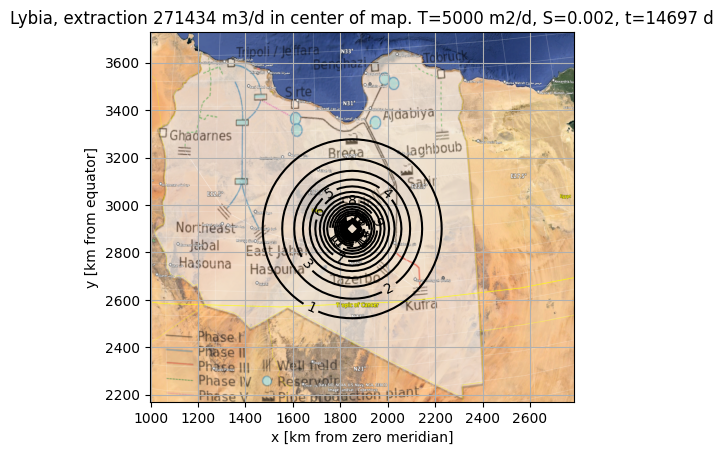

In [21]:
x = np.arange(1000, 2701, 25) # km
y = np.arange(2200, 3601, 25) # km

Xkm, Ykm = np.meshgrid(x, y)

rkm = np.sqrt((Xkm - Xkm.mean())**2 + (Ykm - Ykm.mean())**2)
rm  = 1000 * rkm # r must be in m if T is in m2/d and Q is in m3/d and t is in days

t = days_since_1984

s = dd_theis(rm, Qpd, T, t, S)

ax = plot_lybia()
ax.set_title(f"Lybia, extraction {Qpd:.0f} m3/d in center of map. T={T:.0f} m2/d, S={S:.2g}, t={t:.0f} d")

cs = ax.contour(Xkm, Ykm, s, levels=25, colors='black', linestyles='solid')
ax.clabel(cs)

### For all psites simultaneously

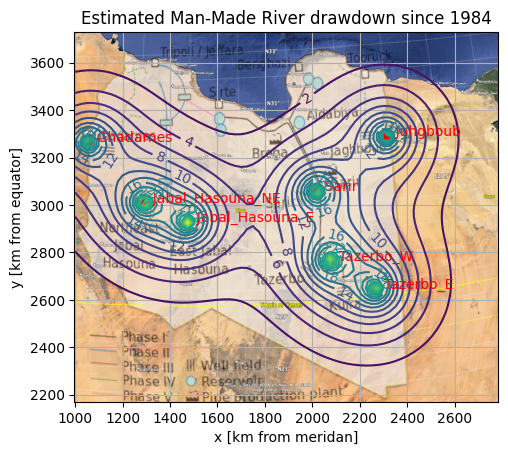

In [22]:
T = aqprops['T']
S = aqprops['S']
t = days_since_1984

ax = plot_lybia()
# fig, ax = plt.subplots()
ax.set_title("Estimated Man-Made River drawdown since 1984")
ax.set_xlabel('x [km from meridan]')
ax.set_ylabel('y [km from equator]')
s = np.zeros(Xkm.shape)
for site_name in psites.index:
    psite = psites.loc[site_name]
    xkm, ykm, Qpd = psite[['xkm', 'ykm', 'Qpd']]
    rkm = np.sqrt((Xkm - xkm) ** 2 + (Ykm -ykm) ** 2)
    rm =  rkm * 1000.
    u = rm ** 2 * S  /(4 * T * t)
    s += Qpd / (4 * np.pi * T) * Wt(u)
    ax.plot(xkm, ykm, 'ro')
    ax.text(xkm, ykm, '  ' + site_name, color='red')
cs = ax.contour(Xkm, Ykm, s, levels=25)
ax.clabel(cs)

plt.show()


### Compute the drawdown over time at the Egypian border at (x=2522.2, y=2782.9)

In [23]:
psites.loc['Tazerbo_W', ['xkm', 'ykm']]

xkm    2075.5
ykm    2766.6
Name: Tazerbo_W, dtype: float64

In [24]:
T = aqprops['T']
S = aqprops['S']

sete_name = 'Tazerbo_W'
xPS, yPS, Qpd = psites.loc[site_name, ['xkm', 'ykm', 'Qpd']]

lonlatEgypt = np.array([[25, 25]]) # Degrees WGS84
xEgypt, yEgypt = wgs2km(lonlatEgypt)[0] # in km

t =  (2024 - 1984) * 365  # days since start

rEg_km = np.sqrt((xEgypt - xPS) ** 2 + (yEgypt - yPS) ** 2)
rEg_m = rEg_km * 1000 # in m

ddEg = Qpd / (4 * np.pi * T) * exp1(rEg_m ** 2 * S / (4 * T * t))

print(f"Dd Egypt border at {rEg_km:.0f} km from {site_name} over {2024 - 1984} years: {ddEg:.2f} m")

Dd Egypt border at 548 km from Jahgboub over 40 years: 0.19 m


### Compute the drawdown over time (1984-2024) at 1000 m from the point Tazerbo assuming this is the approximate radius of the pumping well ensemble.

Just use he same formula with r = 1000 m !

In [25]:
r = 1000 # in m

dd1km = Qpd / (4 * np.pi * T) * exp1(r ** 2 * S / (4 * T * t))

print(f"Ddn  at r = {r:.0f} m from pumping site Q = {Qpd:.0f} m3pd, kD = {T:.0f} m2/s, S = {S:.2g}, after {2024 - 1984} years is {dd1km:.1f} m")

Ddn  at r = 1000 m from pumping site Q = 271434 m3pd, kD = 5000 m2/s, S = 0.002, after 40 years is 48.9 m



## 2 Nasser lake impact on adjacent groundwater 
####  1. Show the lake level and the measured heads

Show the lake level and the measured heads as a funciton of time in graphs in a single plot. For this you need to read the data into your notebook and plot them.

#### 2. Construct and test your model

Your model will be the analytic solution that gives the change of head
over time caused by a sudden change of head [m] at . That is:
Use convolution (i.e. moving average weighted by the response) to simulate the head at the locations

for which you were given the piezometer data. Show the results in the same plot together with the lake level and the measurements.

Note that the Step Response
is the effect of a sudden change at by m! Further realize that the change of head from one day to the next is a sudden change on that day.
The model is Simply the convolution (moving average) that is done by the function scipy.signal.lfilter(SR, 1, np.diff(hLake)) where np.diff(hLake) is an array of the day-to-day changes of the lake level. np.diff just computes hlake[i+1] - hlake[i] or compactor without neding a loop, hlake[1:] - hlake[:-1].


### 3. Show that your model works.
During a pumping test in a well the head, and therefore, the drawdown, is measured in a whole series of observation wells. By showing the drawdowns as a function of the logarithm of time since the start of the pumping, a good insight in the reaction of the groundwater due to the pumping. It becomes obvious that the behavior is neither completely according to Theis, nor completely according to Hantush. But we can still analyze it whith the solutions that Theis and Hantush have given us. Analyze the pumping test, given the aquifer (and aquitard) characteristics and explain what is happening here, and therefore, why pumping tests should not be too short, especially what circumstances can make the answer tricky if the pumping test is too short. 2. Impact of long-level rise of Lake Nasser (Egypt) on adjacent groundwater

Lake Nasser (Egypt) was formed after construction of the Assuan Dam in the early 20th century. The high dam was ready in 1965, after which Lake Nasser started to rise and extend until what it is today. The rise of the Lake between 1965 and 2005 is shown in the graph. The data with the water level over time is also given. The rise of the lake level causes infiltration of Lake / Nile water into the aquifers adjacent to the lake. The groundwater in these aquifer will continue to rise over centuries while these aquiers slowly fill up. Full equilibirium will likely never be reached because there are not fixed head boundaries that could cause equilibrium to establish. But then the question raises, how far and to what exent does the groundwater rise? Will low areas get wet and form salt lakes? Can the new groundwater be used for agriculture and when and to what exent, and so on. To answer such questions you are asked to quantify the gradual rise of the grounwater in points at different distances from the lake lying in a cross section.

But to be able to quantify the effect and predict the future of it, you well need to calibrate you parameters kD and S. You can do that by matching your model with observations. Observed heads are available at 6 piezometers situated at different distances from the lake. For each piezometer the head is available for a number of times. You can do the calibration by hand, by changing the kD and the S and run the simulation again until your model matches the data. It is believed from the data obtained from drilling of the piezometers when they were intstalled, that the transmissivity will be in the order of 600 m2/d and the storage coefficient in the order of 5%. So these values are a good starting point for your calibration. Questions

#### Get the data directory and assert it exists

In [26]:
dirname = os.path.join(DATA, 'lake_nasser')
print(dirname)
assert os.path.isdir(dirname), "Can't find directory {} !".format(dirname)

/Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/ToTheStudents/Isaq_Tuna/data/lake_nasser


#### Get the lake data into a pd.DataFrame

1. Then make the index np.DateTime types
2. And give the index a name `date`.
3. Show first few recoreds.

In [27]:
lake = pd.read_csv(os.path.join(dirname, 'nasser_lake.csv'), index_col=0)
lake.index = [np.datetime64(f) for f in lake.index]
lake.index.name = 'date'
lake.head()

level
date              
1965-03-12  126.30
1965-03-13  126.27
1965-03-14  126.24
1965-03-15  126.20
1965-03-16  126.17

#### Plot the lake level vs. time

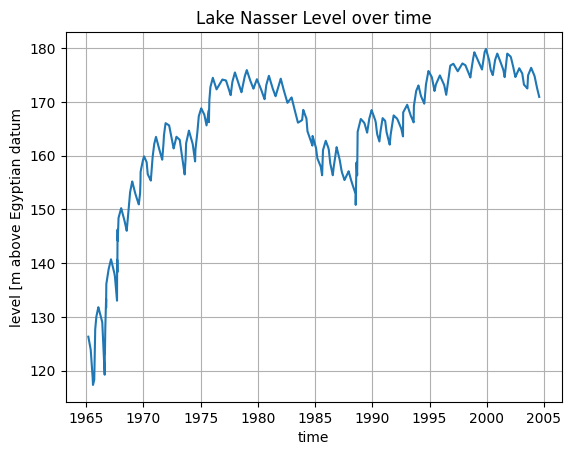

In [28]:
plt.title("Lake Nasser Level over time")
plt.ylabel("level [m above Egyptian datum")
plt.xlabel('time')
plt.grid()
plt.plot(lake)
plt.show()

#### Get the head data

1. Get the head files
2. Turn them in pd.DataFrames and convert index from str to np.DateTime64 objects
3. Put the DataFrames and the distance x into a dictionary named `piezoms`

In [30]:
head_files = [f for f in glob(NASSER + '/*') if os.path.basename(f).startswith('head')]
pprint(head_files)

piezoms = {}
for fname in head_files:
    basename = os.path.basename(fname)
    x = int(basename[6:-4])
    df = pd.read_csv(fname, index_col=0, parse_dates=True)
    piezoms[basename] = {'x': x, 'head': df}

for k in piezoms:
    pz = piezoms[k]
    print(f"\n{k}, x={pz['x']} m\n")
    print(pz['head'].head())

['/Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/ToTheStudents/Isaq_Tuna/data/lake_nasser/headAt908.csv',
 '/Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/ToTheStudents/Isaq_Tuna/data/lake_nasser/headAt9497.csv',
 '/Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/ToTheStudents/Isaq_Tuna/data/lake_nasser/headAt256.csv',
 '/Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/ToTheStudents/Isaq_Tuna/data/lake_nasser/headAt30678.csv',
 '/Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/ToTheStudents/Isaq_Tuna/data/lake_nasser/headAt2972.csv']

headAt908.csv, x=908 m

                x           h
date                         
1968-07-02  908.0  136.255080
1974-07-30  908.0  148.346874
1974-10-08  908.0  149.154260
1977-07-12  908.0  155.684368
1982-03-20  908.0  158.046527

headAt9497.csv, x=9497 m

                 x           h
date                          
1966-09-19  9497.0  126.282137
1967-03-27  9497.0  126.322701
1971-05-25  9497.0  128.495484
1973-07-29  9497.0  129.95362

###  Set up a model and show

1. Show the measurements
2. Set up your model to simulate them

#### Show the measurements

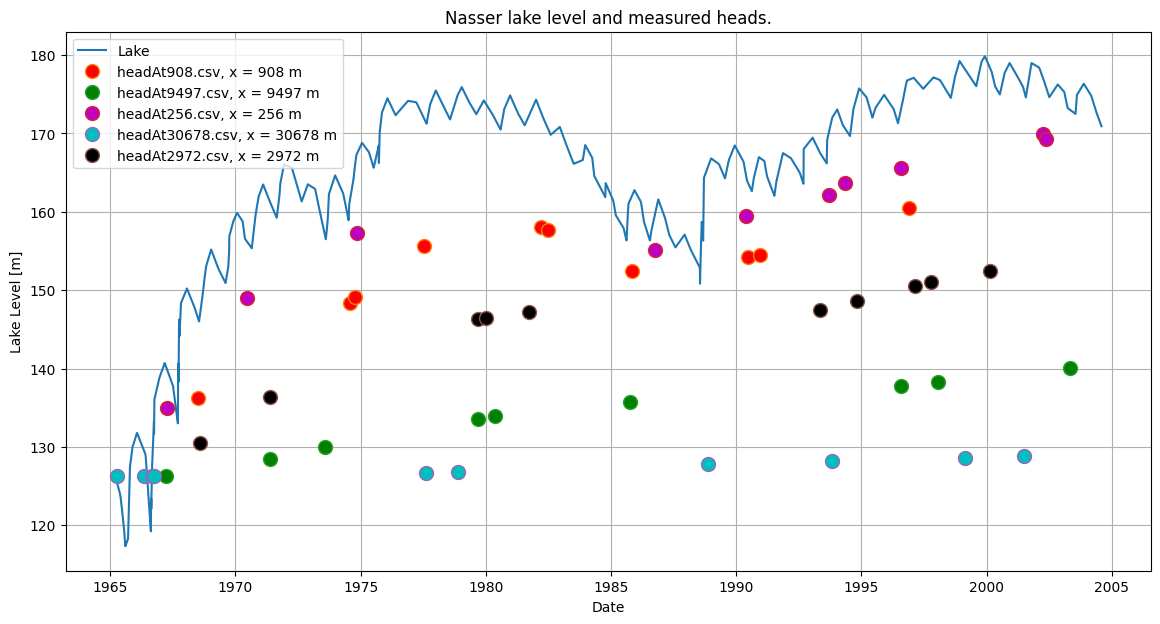

In [33]:
fig, ax = plt.subplots(figsize=(14, 7))

ax.set_title('Nasser lake level and measured heads.')
ax.set_xlabel('Date')
ax.set_ylabel('Lake Level [m]')
ax.grid()

ax.plot(lake['level'], label='Lake')

clrs = cycle('brgmck')
color =  next(clrs)

for k in  piezoms:
    pz = piezoms[k]
    ax.plot(pz['head']['h'], 'o', mfc=next(clrs), ms=10, label=f'{k}, x = {pz['x']} m')
    
ax.legend(loc='upper left')

plt.show()

### Construct model to simulate the heads

1. Set up a model that will simulate the head by convolution
2. Show it

#### Set up the model (convolution)

We will use the `erfc` function for a unit sudden change of head at x = 0 as a step response. To use this in a simulation, we have to convolve it with the daily head changes, not the heads.

In [60]:
def SR(x, S, T, tau):
    """Return step response for point at x, due to sudden change at x=0."""
    u = x * np.sqrt(S / (4 * T * tau))
    return erfc(u)

# Calculating day-to-day lake level changes
assert np.all(np.diff(lake.index)), "All time steps must be the same!"

lake_dh = np.diff(lake['level'].values)
print('lake_dh: ', lake_dh[:10], '...')

lake_dh:  [-0.03 -0.03 -0.04 -0.03 -0.03 -0.03 -0.03 -0.04 -0.03 -0.03] ...


#### Simulating the heads using convolution (signal.convolve and signal.lfilter)

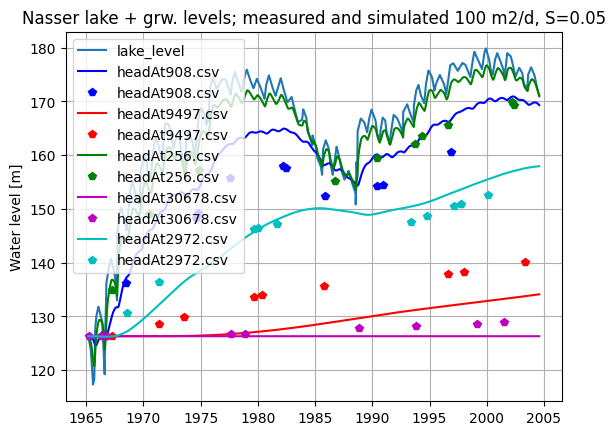

In [66]:
S = 0.05
T = 100

# Simulation time (floats in days)
tau = np.asarray((lake.index - lake.index[0]) / np.timedelta64(1, 'D'))[1:]

fig, ax = plt.subplots()
ax.set_title(f"Nasser lake + grw. levels; measured and simulated {T} m2/d, S={S}")
ax.set_ylabel("Water level [m]")
ax.grid()

ax.plot(lake['level'], label='lake_level')

clrs = cycle('brgmck')

hstart = lake['level'][lake.index[0]]

for k in piezoms:
    clr = next(clrs)        
    pz = piezoms[k]
    x = pz['x']    
    hsim = lfilter(SR(x, S, T, tau), 1, lake_dh) + hstart
    ax.plot(lake.index[1:], hsim, color=clr, label=k)
    ax.plot(pz['head']['h'], 'p', color=clr, label=k)

ax.legend(loc='best')
plt.show()



#### Conclusion
It looks like the piezometer distances are not correct, because the simulation does not fit the data, despite there being only one parameter, i.e. T/S. Hence, further analysis of the quallity of the data is required.

#### Compute the total inflow between 1965 and 2005
We do this with convolution and with lfilter.

Total infiltration from 1965 through 2005: 12889 m3/m


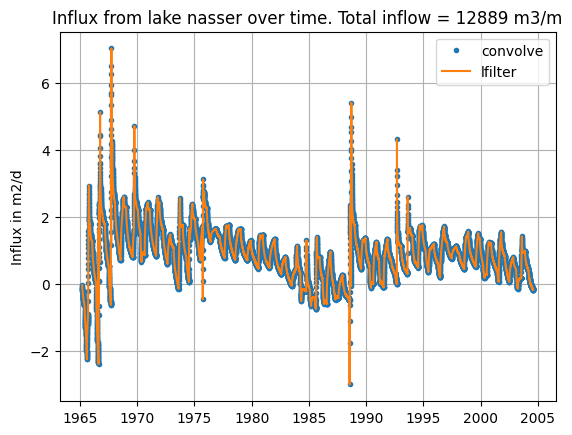

In [77]:
def SR_Qin(S, T, tau):
    return np.sqrt(T * S / (np.pi * tau))

Sy = 0.05  # Initial specific yield
kD = 600  # Initial hydraulic conductivity * aquifer thickness (m^2/day)

qsim1 = convolve(lake_dh, SR_Qin(S, T, tau), mode='full')[:len(lake_dh)]
qsim2 = lfilter(SR_Qin(S, T, tau), 1, lake_dh)

Vtotal = np.sum(qsim1)

print(f"Total infiltration from 1965 through 2005: {Vtotal:.0f} m3/m")

plt.title(f"Influx from lake nasser over time. Total inflow = {Vtotal:.0f} m3/m")
plt.ylabel("Influx in m2/d")
plt.grid()
plt.plot(lake.index[1:], qsim1, '.', label='convolve')
plt.plot(lake.index[1:], qsim2, label='lfilter')

plt.legend()

## 4. Hantush and Theis type curves

1. Question

Show the type curves for the Hantush and Theis well functions. A type curve shows the well function on double log scales as a function of 1/u. The Hantush well function does this for different values of
For the Hantush well function use the following values for rho=r/lambda:

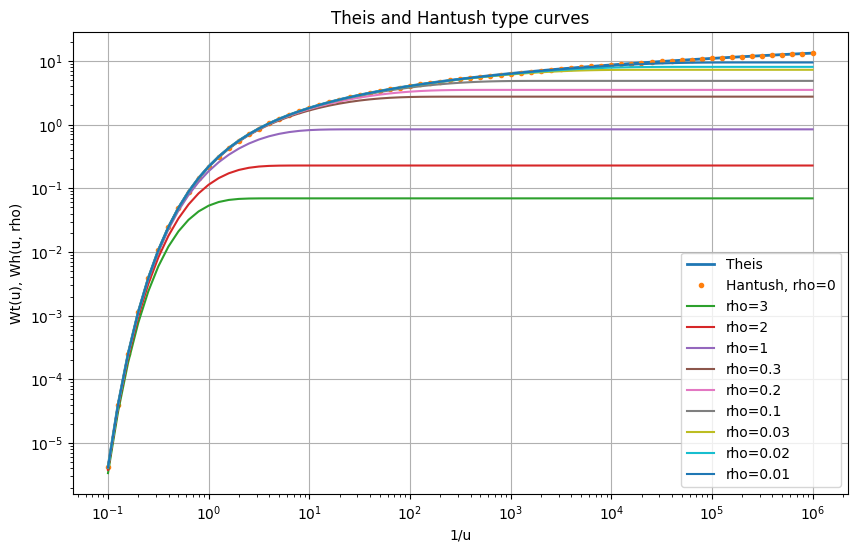

In [86]:
u = np.logspace(-6, 1, 71)

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_title("Theis and Hantush type curves")
ax.set_xlabel('1/u')
ax.set_ylabel('Wt(u), Wh(u, rho)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.plot(1/u, Wt(u), '-', lw=2, label='Theis')
ax.plot(1/u, Wh(u), '.', lw=2, label='Hantush, rho=0')
ax.grid()


rhos = [3, 2, 1, 0.3, 0.2, 0.1, 0.03, 0.02, 0.01]
for rho in rhos:
    ax.plot(1/u, Wh(u, rho), label=f'rho={rho:.3g}')
ax.legend()

## 5. Pumping experiment

There was a pumping test in an aquifer covered by a shallow clay layer on top of which is a sand layer with a very low transmissivity. This sand layer has a water level that is only affected by rain, evaporation and leakage. Ignore the rain and precipitation.

The pumping was done in below the clay layer. The drawdown in both the top and bottom layers was measured in six piezometers during the entire long pumping test. These drawdowns for each distance to the well are in the accompanying directory in a set of `piez###m.csv` files. Each one has the time of measurement and the drawdown in the top and bottom layers (aquif1 and aquif2).

In the same directory is a file `Q.txt` which says what the discharge of the well was.

You can read the data in the file using pandas like so:

#### Get the data

1. Check the directory with the data
2. The the csv files
3. Store their data in to a dictioinary named piezoms

In [87]:
ptest_dir = PTEST
assert os.path.isdir(ptest_dir), "Can't open your pump_test directory!"
print('ptest_dir:\n', ptest_dir)

ptest_dir:
 /Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/ToTheStudents/Isaq_Tuna/data/pump_test


In [103]:
# Print the names of files in the directory
ptst_ddn_files = glob(PTEST + '/*')
ptst_ddn_files

['/Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/ToTheStudents/Isaq_Tuna/data/pump_test/piez9m.csv',
 '/Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/ToTheStudents/Isaq_Tuna/data/pump_test/piez88m.csv',
 '/Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/ToTheStudents/Isaq_Tuna/data/pump_test/piez52m.csv',
 '/Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/ToTheStudents/Isaq_Tuna/data/pump_test/piez19m.csv',
 '/Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/ToTheStudents/Isaq_Tuna/data/pump_test/piez121m.csv',
 '/Users/Theo/Entiteiten/IHE/IHE2023-2024/Assignment/ToTheStudents/Isaq_Tuna/data/pump_test/piez34m.csv']

In [105]:
ptest_piezoms = dict()
for fname in ptst_ddn_files:
    basename = os.path.basename(fname)
    r = float(basename[4:-5])
    pdf = pd.read_csv(os.path.join(ptest_dir, fname))
    pdf.index = pdf['time_d'] # Use the time_d as index
    pdf = pdf.drop(labels=['time_d'], axis=1) # drop column ['time_d'] it's now the index
    ptest_piezoms[basename] = {'r':r, 'ddn':pdf}

# @TO now we have the dictionary:
print('ptest_piezoms.keys:\n', ptest_piezoms.keys())
for k in ptest_piezoms.keys():
    pz = ptest_piezoms[k]
    print(f"\npiezoms['{k}']\nr = {pz['r']} m\n", pz['ddn'].head(4)) # only 10 lines

ptest_piezoms.keys:
 dict_keys(['piez9m.csv', 'piez88m.csv', 'piez52m.csv', 'piez19m.csv', 'piez121m.csv', 'piez34m.csv'])

piezoms['piez9m.csv']
r = 9.0 m
         aquif1  aquif2
time_d                
0.0100   0.005   0.375
0.0149   0.004   0.403
0.0221   0.008   0.444
0.0329  -0.003   0.469

piezoms['piez88m.csv']
r = 88.0 m
         aquif1  aquif2
time_d                
0.0100  -0.003   0.040
0.0149  -0.000   0.063
0.0221   0.005   0.089
0.0329   0.001   0.107

piezoms['piez52m.csv']
r = 52.0 m
         aquif1  aquif2
time_d                
0.0100  -0.003   0.104
0.0149   0.003   0.126
0.0221   0.000   0.160
0.0329   0.004   0.186

piezoms['piez19m.csv']
r = 19.0 m
         aquif1  aquif2
time_d                
0.0100  -0.001   0.254
0.0149  -0.001   0.286
0.0221  -0.001   0.322
0.0329   0.005   0.349

piezoms['piez121m.csv']
r = 121.0 m
           aquif1    aquif2
time_d                    
0.0100  0.002014  0.019506
0.0149 -0.001366  0.030238
0.0221 -0.000651  0.050424
0.0329  0.

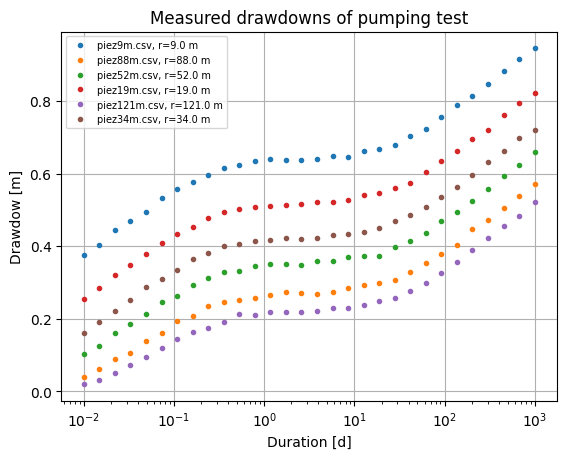

In [98]:
fig, ax = plt.subplots()
ax.set_title("Measured drawdowns of pumping test")
ax.set_xlabel("Duration [d]")
ax.set_ylabel("Drawdow [m]")
ax.grid()
ax.set_xscale('log')

for k in ptest_piezoms:
    pz = ptest_piezoms[k]
    r = pz['r']
    ddn = pz['ddn']        
    ax.plot(ddn['aquif2'], '.', label=f"{k}, r={pz['r']} m")
ax.legend(fontsize=7)


#### 1.  Interprete the first part of the measurement lines to determine the transmissivity and the storage coefficient.

With the obtaind kD and S, compute the darwdown according to Theis and plot them with thin lines. Use linewidth (lw=0.5 or so) in the plt.plot command.

### Although we can do th ecalibration easily by hand, let's do proper curve fitting

In [116]:
def theis_ddn(t, r, T, S, Q):
    u = (r ** 2 * S) / (4 * T * t)
    return (Q / (4 * np.pi * T)) * exp1(u)

def theis1(t, T, S):
    global r, Q
    u = (r**2 * S) / (4 * T * t)
    return (Q / (4 * np.pi * T)) * exp1(u)

def fit_theis(time, drawdown, T=None, S=None):
    params, cov = curve_fit(theis1, time, drawdown, p0=(T, S))
    return params

#### 2.  Try also to match the first part of the curve (behaving fully acc. to Theis)

You can now add the Hantush drawdown to the plot. They should coincide with the Theis ones in the fist part.

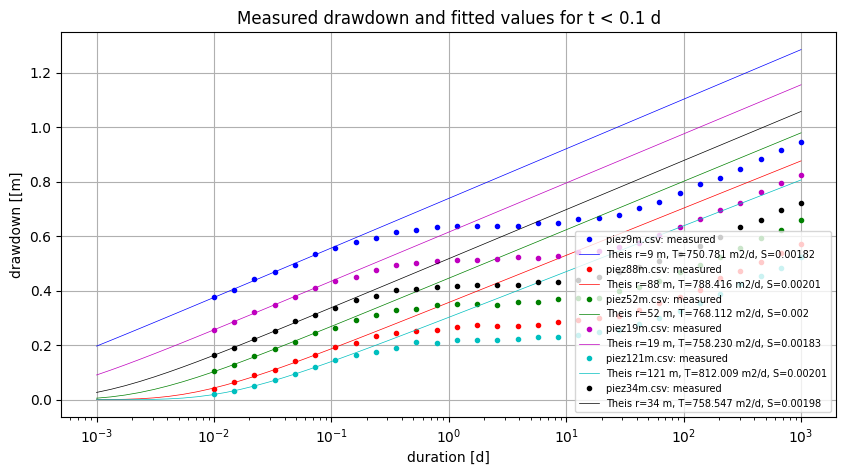

In [117]:
tmax = 0.1 # d, # limit curve fitting to t < tmax

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title(f'Measured drawdown and fitted values for t < {tmax} d')
ax.set_xlabel('duration [d]')
ax.set_ylabel('drawdown [[m]')
ax.set_xscale('log')
ax.grid()

Q = 746 # m3/d Given discharge

clrs = cycle('brgmck')
for k in ptest_piezoms:
    clr = next(clrs)
    pz = ptest_piezoms[k]    
    r = pz['r']
    dd = pz['ddn']['aquif2']
    L = dd.index < tmax
    
    (T_, S_) = fit_theis(dd.index[L], dd.values[L],  T=T, S=S)

    pz['T1'] = T_
    pz['S1'] = S_

    # Plot meaurements
    t_meas = dd.index[L]
    ax.plot(dd, '.', color=clr, label=f'{k}: measured')

    # Plot simulate drawdown for this pz and calibrated T and S
    t = np.logspace(-3, np.log10(dd.index[-1]), 50)
    u = r ** 2 * pz['S1'] / (4 * pz['T1'] * t)
    ax.plot(t, Q / (4 * np.pi * pz['T1']) * exp1(u), color=clr, lw=0.5, label=f'Theis r={pz['r']:.0f} m, T={pz['T1']:.3f} m2/d, S={pz['S1']:.3g}')

ax.legend(loc='lower right', fontsize=7)
plt.show()

We got a prefect fit of the first branch of the drawdown (t < tmax)

## Try to match the curve including the hoirzontal part (seems Hantush type), set tmax=1 d

We will now  optimize the parameters T, S, anc c that determine the Hantush drawdown.

In [111]:
def hantush_dd(t, lnT=None, lnS=None, lnc=None):
    """Return darwdown according to Hantush.

    gloabls
    -------
    r: float
        distance [m]
    Q: float
        discharge [m3/d]

    Parameters
    ----------
    t: float
        time [d]
     T, S: float, float
         transmissibity [m2/d], storage coefficient [-]
    c: float
        Vertical hydraulic resistance of layer on top of aquifer [d]
    """
    global r, Q
    T = np.exp(lnT)
    S = np.exp(lnS)
    c = np.exp(lnc)
    u = (r ** 2 * S) / (4 * T * t)
    rho = r / np.sqrt(T * c)
    return Q / (4 * np.pi * T) * Wh(u, rho)

def fit_hantush(time, drawdown, T=None, S=None, c=None):
    """return calibrated params T, S, c."""    
    p0 = (np.log(T), np.log(S), np.log(c))
    params, covariance = curve_fit(hantush_dd, time, drawdown, p0=p0)
    return params

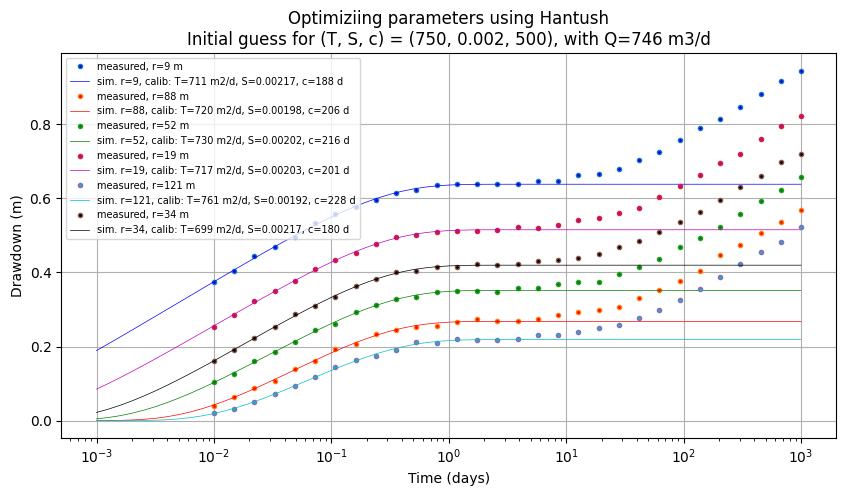

In [112]:
# Initial values
T, S, c = 750, 0.002, 500 # initial guess for kD, S, 
Q = 746 # m3/d

tmax = 4. # d (just before the drawdowns become transient again (see figure of the measure drawdowns)

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title(f"Optimiziing parameters using Hantush\nInitial guess for (T, S, c) = ({T}, {S}, {c}), with Q={Q} m3/d")
ax.set_xlabel('Time (days)')
ax.set_ylabel('Drawdown (m)')
ax.set_xscale('log')
ax.grid()

clrs = cycle(['b', 'r', 'g', 'm', 'c', 'k'])

# Loop over each CSV file
for k in ptest_piezoms:
    clr = next(clrs)  # Next color
    pz = ptest_piezoms[k]
    r = pz['r']
    dd = pz['ddn']['aquif2']
    L = dd.index < tmax
    
    (lnT, lnS, lnc) = fit_hantush(dd.index[L], dd.values[L], T=T, S=S, c=c)
    pz['T2'] = np.exp(lnT)
    pz['S2'] = np.exp(lnS)
    pz['c2'] = np.exp(lnc)

    # Plot measurements
    ax.plot(dd.index, dd.values, '.', mfc=clr, label=f'measured, r={r:.0f} m')

    # plot simulated values
    ts = np.logspace(-3, 3, 61)      # Simulation time
    u = r ** 2 * pz['S2'] / (4 * pz['T2'] * ts)
    rho = r / np.sqrt(pz['T2'] * pz['c2'])    
    ss = Q / (4 * np.pi * pz['T2']) * Wh(u, rho)
    
    ax.plot(ts, ss, lw=0.5, color=clr,
        label=f'sim. r={r:.0f}, calib: T={pz['T2']:.0f} m2/d, S={pz['S2']:.3g}, c={pz['c2']:.0f} d')

ax.legend(loc='upper left', fontsize=7)
plt.show()

We got a perfect fit with the data until tmax = 4 days, during which the drawdown behaves like Hantush.

### Calibrate the third branch of the data (t > 4), when once again the behavior is according to Theis.

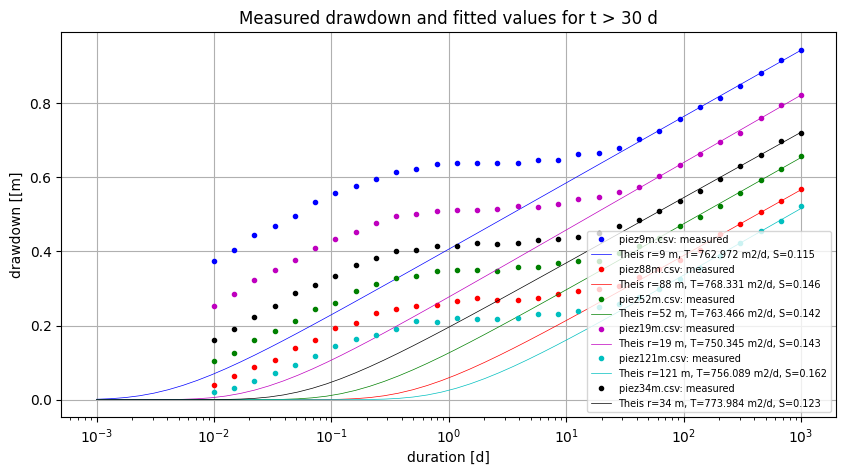

In [113]:
tmin = 30 # d, # limit curve fitting to t > tmin

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_title(f'Measured drawdown and fitted values for t > {tmin} d')
ax.set_xlabel('duration [d]')
ax.set_ylabel('drawdown [[m]')
ax.set_xscale('log')
ax.grid()

Q = 746 # m3/d Given discharge

clrs = cycle('brgmck')
for k in ptest_piezoms:
    clr = next(clrs)
    
    pz = ptest_piezoms[k]
    r = pz['r']
    dd = pz['ddn']['aquif2']
    
    L = dd.index > tmin
    
    # Fit T and S for this piezometer
    (T_, S_) = fit_theis(dd.index[L], dd.values[L],  T=T, S=S)

    # Add to dictionary
    pz['T3'] = T_
    pz['S3'] = S_

    # Plot meaurements
    t_meas = dd.index[L]
    ax.plot(dd, '.', color=clr, label=f'{k}: measured')

    # Plot simulate drawdown for this pz and calibrated T and S
    t = np.logspace(-3, np.log10(dd.index[-1]), 50)
    u = r ** 2 * pz['S3'] / (4 * pz['T3'] * t)
    ax.plot(t ,Q / (4 * np.pi * pz['T3']) * exp1(u), color=clr, lw=0.5, label=f'Theis r={pz['r']:.0f} m, T={pz['T3']:.3f} m2/d, S={pz['S3']:.3g}')

ax.legend(loc='lower right', fontsize=7)
plt.show()

### Same thing but add the ddn measurements of aquif1 (top layer)

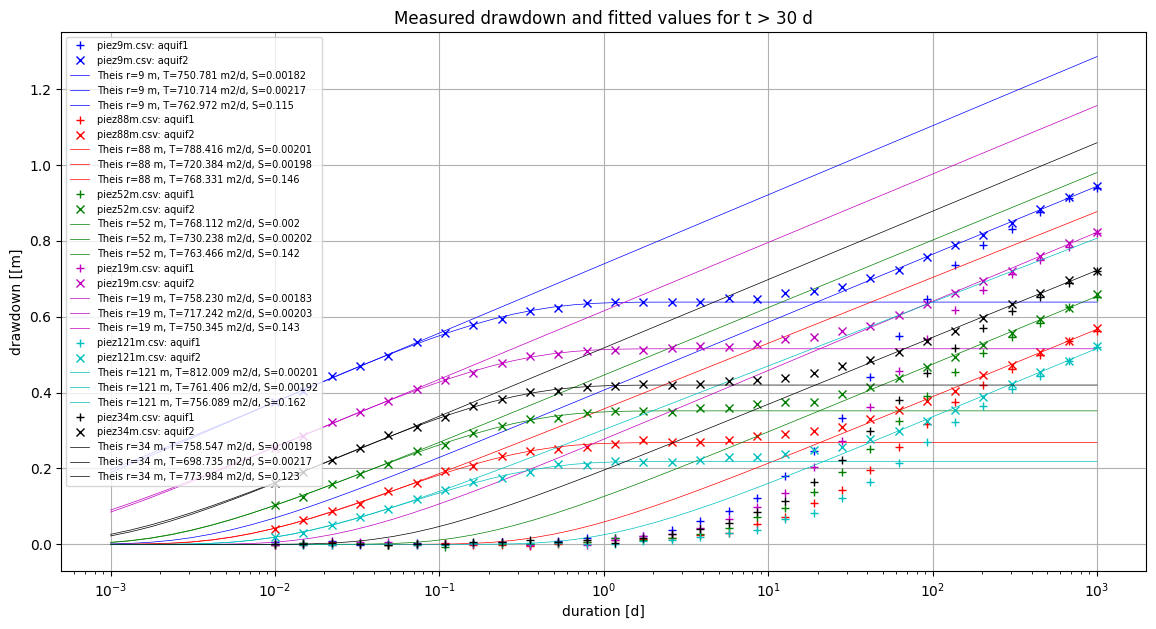

In [123]:
# Plotting
fig, ax = plt.subplots(figsize=(14, 7))
ax.set_title(f'Measured drawdown and fitted values for t > {tmin} d')
ax.set_xlabel('duration [d]')
ax.set_ylabel('drawdown [[m]')
ax.set_xscale('log')
ax.grid()

Q = 746 # m3/d Given discharge

clrs = cycle(['b', 'r', 'g', 'm', 'c', 'k'])
for k in ptest_piezoms:
    clr = next(clrs)
    pz = ptest_piezoms[k]

    dd1 = pz['ddn']['aquif1']
    dd2 = pz['ddn']['aquif2']
    
    t_meas = dd.index[L]
    ax.plot(dd1, '+', color=clr, label=f'{k}: aquif1')
    ax.plot(dd2, 'x', color=clr, label=f'{k}: aquif2')

    # Plot simulate drawdown for this pz and calibrated T and S
    t = np.logspace(-3, np.log10(dd.index[-1]), 50)
    
    u1 = pz['r'] ** 2 * pz['S1'] / (4 * pz['T1'] * t)
    u2 = pz['r'] ** 2 * pz['S2'] / (4 * pz['T2'] * t)
    u3 = pz['r'] ** 2 * pz['S3'] / (4 * pz['T3'] * t)
    rho = pz['r'] / np.sqrt(pz['T2'] * pz['c2'])
    
    ax.plot(t, Q / (4 * np.pi * pz['T1']) * Wt(u1),      color=clr, lw=0.5, label=f'Theis r={pz['r']:.0f} m, T={pz['T1']:.3f} m2/d, S={pz['S1']:.3g}')
    ax.plot(t, Q / (4 * np.pi * pz['T2']) * Wh(u2, rho), color=clr, lw=0.5, label=f'Theis r={pz['r']:.0f} m, T={pz['T2']:.3f} m2/d, S={pz['S2']:.3g}')
    ax.plot(t, Q / (4 * np.pi * pz['T3']) * Wt(u3),      color=clr, lw=0.5, label=f'Theis r={pz['r']:.0f} m, T={pz['T3']:.3f} m2/d, S={pz['S3']:.3g}')

ax.legend(loc='upper left', fontsize=7)
plt.show()

In [115]:
print('The calibrated parameters:\n')
for k in ptest_piezoms:
    pz = ptest_piezoms[k]
    print(f'Piezometer {k}, r={pz['r']:.0f}')
    print(f"Transmissivities for the three branches: {pz['T1']:.0f}, {pz['T2']:.0f}, {pz['T3']:.0f} m2/d")
    print(f"Storage coefficients for the 3 bfanches: {pz['S1']:.2g}, {pz['S2']:.2g}, {pz['S3']:.2g} [-]")
    print(f"Resistance between aquifeers 1 and 2   : {pz['c2']:.0f} d")
    print()
    

The calibrated parameters:

Piezometer piez9m.csv, r=9
Transmissivities for the three branches: 751, 711, 763 m2/d
Storage coefficients for the 3 bfanches: 0.0018, 0.0022, 0.11 [-]
Resistance between aquifeers 1 and 2   : 188 d

Piezometer piez88m.csv, r=88
Transmissivities for the three branches: 788, 720, 768 m2/d
Storage coefficients for the 3 bfanches: 0.002, 0.002, 0.15 [-]
Resistance between aquifeers 1 and 2   : 206 d

Piezometer piez52m.csv, r=52
Transmissivities for the three branches: 768, 730, 763 m2/d
Storage coefficients for the 3 bfanches: 0.002, 0.002, 0.14 [-]
Resistance between aquifeers 1 and 2   : 216 d

Piezometer piez19m.csv, r=19
Transmissivities for the three branches: 758, 717, 750 m2/d
Storage coefficients for the 3 bfanches: 0.0018, 0.002, 0.14 [-]
Resistance between aquifeers 1 and 2   : 201 d

Piezometer piez121m.csv, r=121
Transmissivities for the three branches: 100, 761, 756 m2/d
Storage coefficients for the 3 bfanches: 0.05, 0.0019, 0.16 [-]
Resistance b

## Conclusion

There are differences between the results for the different piezometers, especially for the resistance $c$. The correlation between the paramters in the Hantush case plays an important role. The higher the correlation is, the more uncertain the outcomes, and the variable will they be. Especially the storage coefficient fo the hantush branch, the second value, becomes most encertain, with a large difference with the two other storage coefficents. This is due to Hantush becoming steady, when storage no long plays a role.

You see, we got an excellent fit after calbrating the parameters with the data over periods when it behaves like Theis or Hantush. The calibfated parameters are mentioned in the legend. There are small differenes between the results obtained from the different piezometer. Of course, one could calibrate over all piezometers at once. That could be done by not using time but by using $t/r^2$, because the drawdown depends on $t/r^2$, which eliminates the dependence on $r$.

The calibration for Hantush is a bit more advanced under the heed. I calibrated the log of the parameters T, S, and c, which prevents that the curve_fit function tries values below zero. To do that, I hac to adapt the handuts_fitt and the hantush_dd functions as well. Not that the function hanush_fit then also yields the log of the improved paramters. That is taken care of in the cell above. Calibrating the log of paramters is a general trick if the parameter value must always remain positive, which is the case for most physical parameters.

### Curve Behaviour:
During the early part of the pumping test, you observe a straight-up curve. This behavior is typical of the early-time response when the drawdown is influenced by the high hydraulic conductivity (K) of the aquifer.
The straight-up curve indicates that the drawdown is primarily controlled by the rapid movement of water toward the pumping well through the highly permeable aquifer.

### Horizontal Phase:
After a certain time, the drawdown curve becomes horizontal. This signifies a transition from the early-time to the late-time response.
The horizontal portion suggests that the flow of water is reaching a more confined or lower-permeability layer within the subsurface. This layer could be a semi-confining layer, a confining layer, or a transition to a less permeable part of the aquifer.

### Straight-Up Phase Again:
Following the horizontal phase, you observe another straight-up curve. This indicates that the drawdown is once again dominated by a higher-permeability zone, possibly as the pumped water bypasses the previously encountered less permeable layer.

### Possible Explanations:
The presence of a semi-confining or confining layer: A layer with lower hydraulic conductivity restricts the vertical movement of water, leading to the horizontal phase. The subsequent straight-up phase could occur when the water moves through a higher-permeability layer.
Changes in lithology: Variations in the geological composition of the subsurface can result in different permeability zones, influencing the drawdown behavior.
Pumping-induced changes: The pumping itself may alter the flow patterns in the aquifer, causing drawdown characteristics to change over time.

#                                            F I N I S H E D